# Model Creation and Evaluation

In this report we build three regression models to predict the error vectors (both magnitude and angle), compare them with a baseline model, and evaluate the model performance by visualizing the mean-absolute error and mean-squared error for both magnitudes and angles of the error vectors.

In [1]:
# Load packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load custom modules
import plotting_tools as pt
from custom_functions import prepare_data, train_predict

In [2]:
# Set the style of display
plt.style.use("ggplot")
%matplotlib inline

### Features Selection and Data Preprocessing

Here we take camera "mx" as an example. We use image "mx2" as training data and "mx3" as test data. We create features (e.g., star centroid to center distance and azimuth angle of star centroid as predictors, and the error vector magnitude and angle as target variables)

In [3]:
# Create the training and test datasets from a given camera
camera = "mx"
image_nums_train = ["2"]
image_nums_test = ["3"]
X_train, y_train = prepare_data(camera, image_nums=image_nums_train)
X_test, y_test = prepare_data(camera, image_nums=image_nums_test)

# Create polynomial features
#pw_list = [2, 3]
#X_train = np.hstack((X_train, np.power(X_train,pw_list[0]), np.power(X_train,pw_list[1])))
#X_test = np.hstack((X_test, np.power(X_test,2), np.power(X_test,3)))

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 115 samples.
Testing set has 112 samples.


## Build Models

#### Build a baseline model

The baseline model always predicts the mean values of the error vector magnitude and angle. The error magnitude is in pixel unit and the angle is in degree.

In [4]:
# Calculate MAE and MSE of the baseline model
baseline_prediction_MAE_train = np.mean(np.abs(y_train - np.mean(y_train, axis=0)), axis=0)
baseline_prediction_MAE_test = np.mean(np.abs(y_test - np.mean(y_test, axis=0)), axis=0)
baseline_prediction_MSE_train = np.square(np.abs(y_train - np.mean(y_train, axis=0))).mean(axis=0)
baseline_prediction_MSE_test = np.square(np.abs(y_test - np.mean(y_test, axis=0))).mean(axis=0)
baseline_error_dict = {"baseline_prediction_MAE_train":baseline_prediction_MAE_train,
                       "baseline_prediction_MAE_test":baseline_prediction_MAE_test,
                       "baseline_prediction_MSE_train":baseline_prediction_MSE_train,
                       "baseline_prediction_MSE_test":baseline_prediction_MSE_test}
baseline_error_mag_dict = {ky:baseline_error_dict[ky][0] for ky in baseline_error_dict.keys()}
baseline_error_ang_dict = {ky:baseline_error_dict[ky][1] for ky in baseline_error_dict.keys()}

In [5]:
baseline_error_dict

{'baseline_prediction_MAE_test': array([  0.5668121 ,  20.20457589]),
 'baseline_prediction_MAE_train': array([  0.53879155,  18.03050224]),
 'baseline_prediction_MSE_test': array([  5.23878143e-01,   6.17229262e+02]),
 'baseline_prediction_MSE_train': array([  3.87374064e-01,   5.37924815e+02])}

#### Build three regression models

We build three regression models (Linear Regressor, Gradient Boosting Regressor and Random Forest Regressor). Since the target variables have two parameters (error vector magnitude and angle), we creat three Multi Output Regressors based on the above threee regression models.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Initialize the three models
# build a linear regression
clf_LR = LinearRegression()

# build a GradientBoosting Regressor model
clf_GB = GradientBoostingRegressor(loss="ls", learning_rate=0.1, n_estimators=10, random_state=16)

# build a Random Forest model
clf_RF = RandomForestRegressor(n_estimators=10, random_state=16)

## Model Evaluation

Now we evaluate the above three model results in terms of mean-absolute error (MAE) and mean-squared error (MSE) of the error vector magnitude.

MultiOutputRegressor trained on 34 samples.
MultiOutputRegressor trained on 57 samples.
MultiOutputRegressor trained on 115 samples.
MultiOutputRegressor trained on 34 samples.
MultiOutputRegressor trained on 57 samples.
MultiOutputRegressor trained on 115 samples.
MultiOutputRegressor trained on 34 samples.
MultiOutputRegressor trained on 57 samples.
MultiOutputRegressor trained on 115 samples.


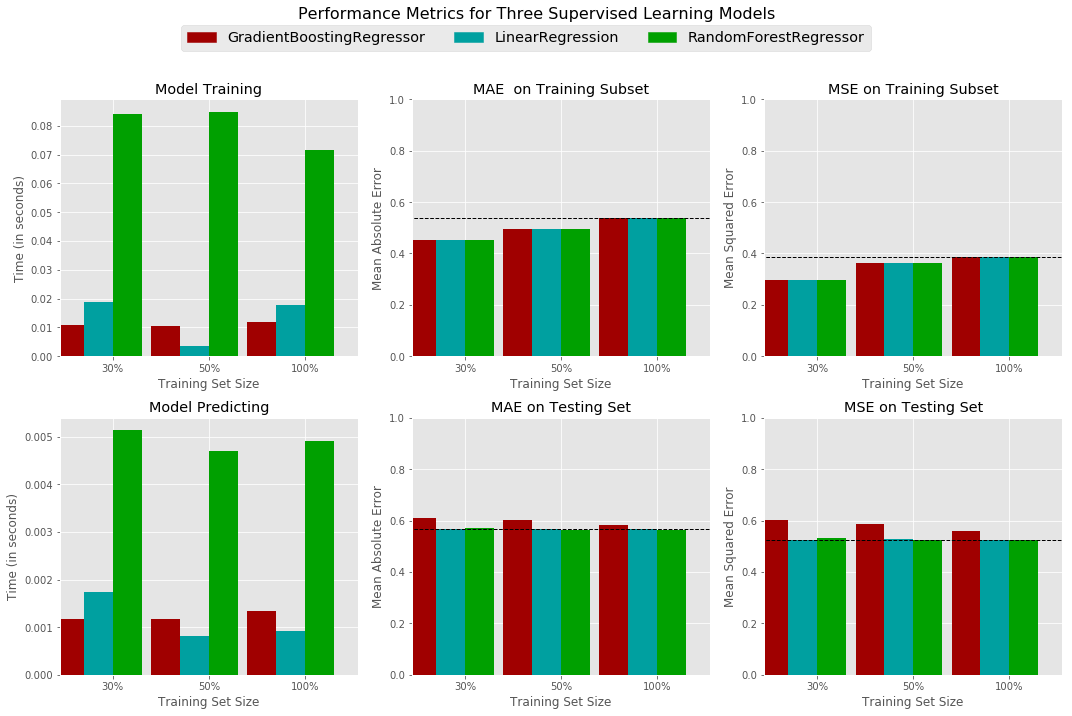

In [7]:
# calculate the number of samples for 1%, 10%, and 100% of the training data
samples_30 = int(0.3 * len(X_train))
samples_50 = int(0.5 * len(X_train))
samples_100 = len(X_train)

# collect results on the learners
results = {}
for clf in [clf_LR, clf_GB, clf_RF]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    clf = MultiOutputRegressor(clf)
    for i, samples in enumerate([samples_30, samples_50, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
# Run metrics visualization for the three models
pt.evaluate(results, baseline_error_mag_dict, params="magnitude")

From the above figures we can see that RandomForest Regressor is performing slighly better than the other models on the test data. Overall, the model results are comparable to the baseline model. However, it does not reflect the model performance on each data point. Now we evaluate the model results in terms of absolute error (AE) of the error vector magnitude

(0, 3.0)

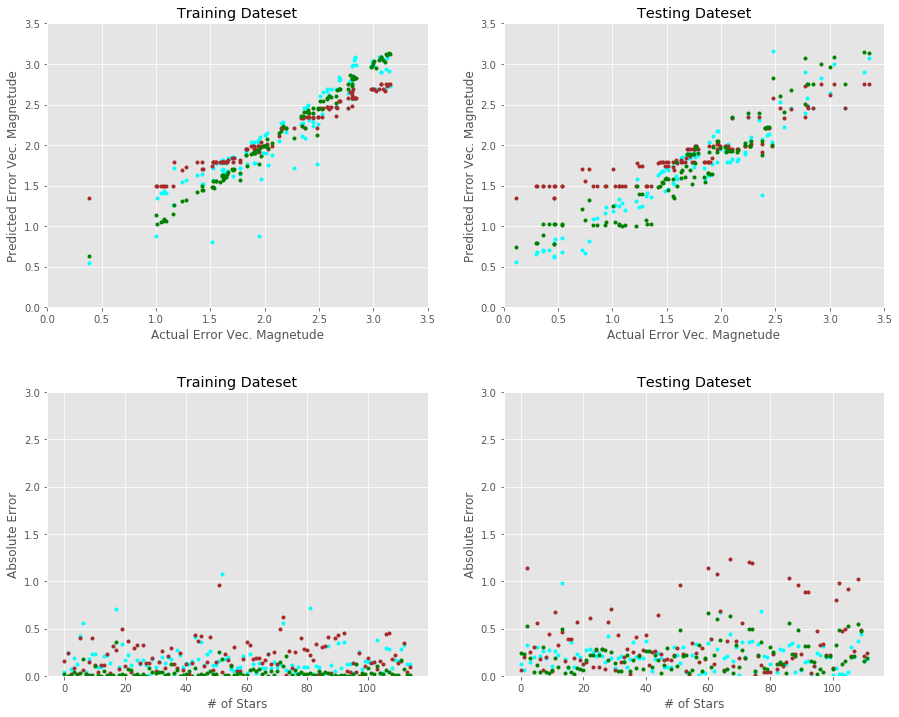

In [8]:
fig, axes = plt.subplots(2,2, figsize=(15,12))
plt.subplots_adjust(hspace=0.3)
colors = ['cyan', 'brown', 'green']
for i, clf in enumerate([clf_LR, clf_GB, clf_RF]):
    # Plot the predicted error magnitude vs "true" error magnitude for training data
    clf_name = clf.__class__.__name__
    yhat_train = results[clf_name][2]["yhat_train"]
    axes[0,0].plot(y_train[:,0], yhat_train[:,0], '.', color=colors[i])
    axes[0,0].set_xlabel("Actual Error Vec. Magnetude")
    axes[0,0].set_ylabel("Predicted Error Vec. Magnetude")
    axes[0,0].set_title("Training Dateset")
    
    # Plot the predicted error magnitude vs "true" error magnitude for testing data
    yhat_test = results[clf_name][2]["yhat_test"]
    axes[0,1].plot(y_test[:, 0], yhat_test[:, 0], '.', color=colors[i])
    axes[0,1].set_xlabel("Actual Error Vec. Magnetude")
    axes[0,1].set_ylabel("Predicted Error Vec. Magnetude")
    axes[0,1].set_title("Testing Dateset")
    
    # Plot the MAE for training data
    AE_train = np.abs(yhat_train[:, 0] - y_train[:, 0])
    axes[1,0].plot(AE_train, '.', color=colors[i])
    axes[1,0].set_ylabel("Absolute Error")
    axes[1,0].set_xlabel("# of Stars")
    axes[1,0].set_title("Training Dateset")
    
    # Plot the MAE for testing data
    AE_test = np.abs(yhat_test[:, 0] - y_test[:, 0])
    axes[1,1].plot(AE_test, '.', color=colors[i])
    axes[1,1].set_ylabel("Absolute Error")
    axes[1,1].set_xlabel("# of Stars")
    axes[1,1].set_title("Testing Dateset")
    
axes[0,0].set_xlim([0, 3.5])
axes[0,1].set_xlim([0, 3.5])
axes[0,0].set_ylim([0, 3.5])
axes[0,1].set_ylim([0, 3.5])
axes[1,0].set_ylim([0, 3.0])
axes[1,1].set_ylim([0, 3.0])

The above figures show that, although the overall result is similar to the baseline model, the three models predict each error vector magnitude reasonably well. Now we evaluate the model results in terms of absolute error (AE) of the error vector angle.

(0, 90)

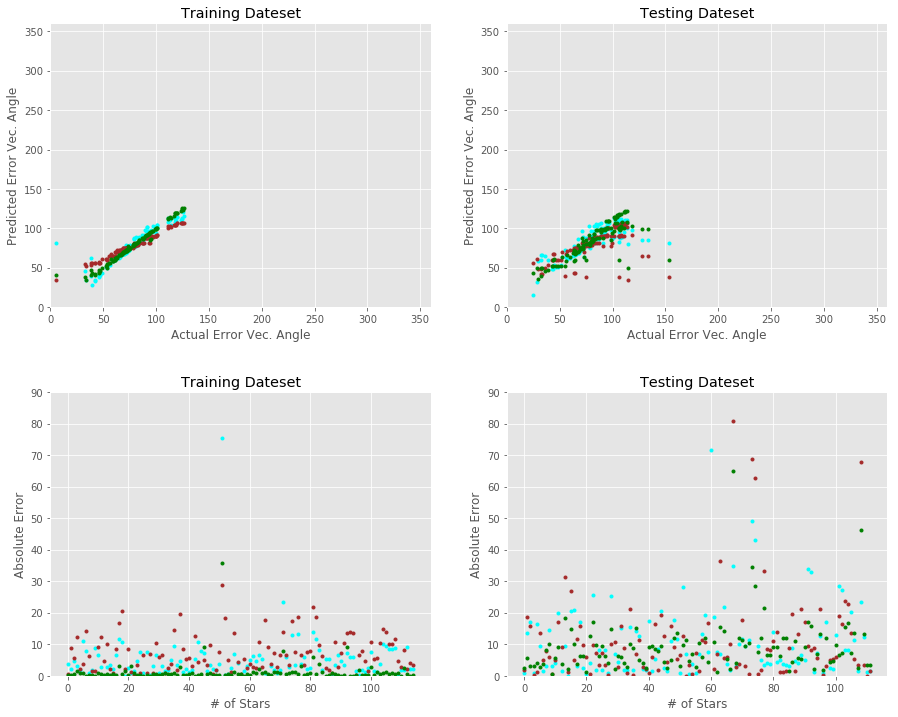

In [9]:
fig, axes = plt.subplots(2,2, figsize=(15,12))
plt.subplots_adjust(hspace=0.3)
colors = ['cyan', 'brown', 'green']
for i, clf in enumerate([clf_LR, clf_GB, clf_RF]):
    # Plot the predicted error magnitude vs "true" error magnitude for training data
    clf_name = clf.__class__.__name__
    yhat_train = results[clf_name][2]["yhat_train"]
    axes[0,0].plot(y_train[:,1], yhat_train[:,1], '.', color=colors[i])
    axes[0,0].set_xlabel("Actual Error Vec. Angle")
    axes[0,0].set_ylabel("Predicted Error Vec. Angle")
    axes[0,0].set_title("Training Dateset")
    
    # Plot the predicted error magnitude vs "true" error magnitude for testing data
    yhat_test = results[clf_name][2]["yhat_test"]
    axes[0,1].plot(y_test[:, 1], yhat_test[:, 1], '.', color=colors[i])
    axes[0,1].set_xlabel("Actual Error Vec. Angle")
    axes[0,1].set_ylabel("Predicted Error Vec. Angle")
    axes[0,1].set_title("Testing Dateset")
    
    # Plot the MAE for training data
    AE_train = np.abs(yhat_train[:, 1] - y_train[:, 1])
    axes[1,0].plot(AE_train, '.', color=colors[i])
    axes[1,0].set_ylabel("Absolute Error")
    axes[1,0].set_xlabel("# of Stars")
    axes[1,0].set_title("Training Dateset")
    
    # Plot the MAE for testing data
    AE_test = np.abs(yhat_test[:, 1] - y_test[:, 1])
    axes[1,1].plot(AE_test, '.', color=colors[i])
    axes[1,1].set_ylabel("Absolute Error")
    axes[1,1].set_xlabel("# of Stars")
    axes[1,1].set_title("Testing Dateset")
    
axes[0,0].set_xlim([0, 360])
axes[0,1].set_xlim([0, 360])
axes[0,0].set_ylim([0, 360])
axes[0,1].set_ylim([0, 360])
axes[1,0].set_ylim([0, 90])
axes[1,1].set_ylim([0, 90])

Similar to the prediction on the error vector magnitude, the models also predicts the error vector angle well. 